## Projet Machine Learning - Determine Football Player Poisition

Authors:
- Grégoire ALPEROVITCH
- Nicolas FLANDIN
- Maxime Chamont

# Introduction

All 3 of us are passionate about football, so we decided to combine our shared passion with our IT skills in this project. In fact, from a computer point of view, football players can be seen as objects with precise statistics that reflect their ability. That's how we came up with the hypothesis that these statistics could be used as factors to determine their role on the pitch. For example, a player with good shooting ability would seem to be an attacker, just as a player who could easily intercept balls would be a defender.

Now that we have these observations, we can start to imagine a machine learning model that can guess a player's position as a defender, striker or midfielder. So here we have our features, which we'll abbreviate as ATT, DEF, MID. To carry out our project we have found on this <a href="https://www.kaggle.com/datasets/nyagami/ea-sports-fc-25-database-ratings-and-stats?select=male_players.csv">link</a>, a database containing all the professional football players with their statistics and their position. 

# Data exploration and analysis

Before training our model or we have to understand the data that we have. We will do a bunch of dataviz technics to findout on what we will focus
To help us develop this model, we will use the pandas, numpy, sklearn and matplotlib packages.

In [14]:
# The package pandas will help us to manipulate the datas into dataframe, a python object for datas
import pandas as pd

file_path = "./male_players.csv"
data = pd.read_csv(file_path)

# Display the columns of the dataframe
print(data.columns)

Index(['Unnamed: 0', 'Rank', 'Name', 'OVR', 'PAC', 'SHO', 'PAS', 'DRI', 'DEF',
       'PHY', 'Acceleration', 'Sprint Speed', 'Positioning', 'Finishing',
       'Shot Power', 'Long Shots', 'Volleys', 'Penalties', 'Vision',
       'Crossing', 'Free Kick Accuracy', 'Short Passing', 'Long Passing',
       'Curve', 'Dribbling', 'Agility', 'Balance', 'Reactions', 'Ball Control',
       'Composure', 'Interceptions', 'Heading Accuracy', 'Def Awareness',
       'Standing Tackle', 'Sliding Tackle', 'Jumping', 'Stamina', 'Strength',
       'Aggression', 'Position', 'Weak foot', 'Skill moves', 'Preferred foot',
       'Height', 'Weight', 'Alternative positions', 'Age', 'Nation', 'League',
       'Team', 'play style', 'url', 'GK Diving', 'GK Handling', 'GK Kicking',
       'GK Positioning', 'GK Reflexes'],
      dtype='object')


The raw CSV file contains complex data, including goalkeepers (GKs) and goalkeepers features with very specific and unique characteristics. These players are excluded from the dataset to prevent them from interfering with the model's training. This cleaning stage is essential to ensure that the data used is homogeneous and suited to the project's objective.

In [15]:
# Data cleansing: remove spaces around positions
data['Position'] = data['Position'].str.strip()

# Exclude goalkeepers (GK) from data 
data = data[data['Position'] != 'GK']

# Excliuse the columns with GK features
data = data.drop(columns=['GK Diving', 'GK Handling', 'GK Kicking', 'GK Positioning', 'GK Reflexes'])

# Show all the positions
print(data['Position'].unique())

['ST' 'CDM' 'CAM' 'LW' 'CM' 'CB' 'RW' 'LB' 'LM' 'RB' 'RM']


The dataset contains a wide variety of specific positions, such as ‘ST’ (top striker), ‘LW’ (left winger), or ‘CM’ (central midfielder). To reduce complexity, these positions have been grouped into three main categories: ‘ATT’ for attacker, ‘MID’ for midfielder, and ‘DEF’ for defender. 

This simplification allows the model to focus on broader distinctions, which improves both the accuracy and robustness of the prediction.

In [16]:
# Position dictionary with main categories
positions = {
    "ATT": ["LW", "RW", "ST"],
    "MID": ["CM", "CDM", "CAM", "LM", "RM"],
    "DEF": ["LB", "RB", "CB"]
}

# Position mapping function
def map_position(position):
    for category, values in positions.items():
        if position in values:
            return category
    return position  # If the position is not in the dictionary, we keep it unchanged

# Applying the `map_position` function to the DataFrame's 'Position' column
data['Position'] = data['Position'].apply(map_position)

We're now going to look at the distribution of features by label, so that first of all we can observe a correlation between features and a label, and know whether certain features are dependent or not. This will also show that this dataset can be used to train a model.

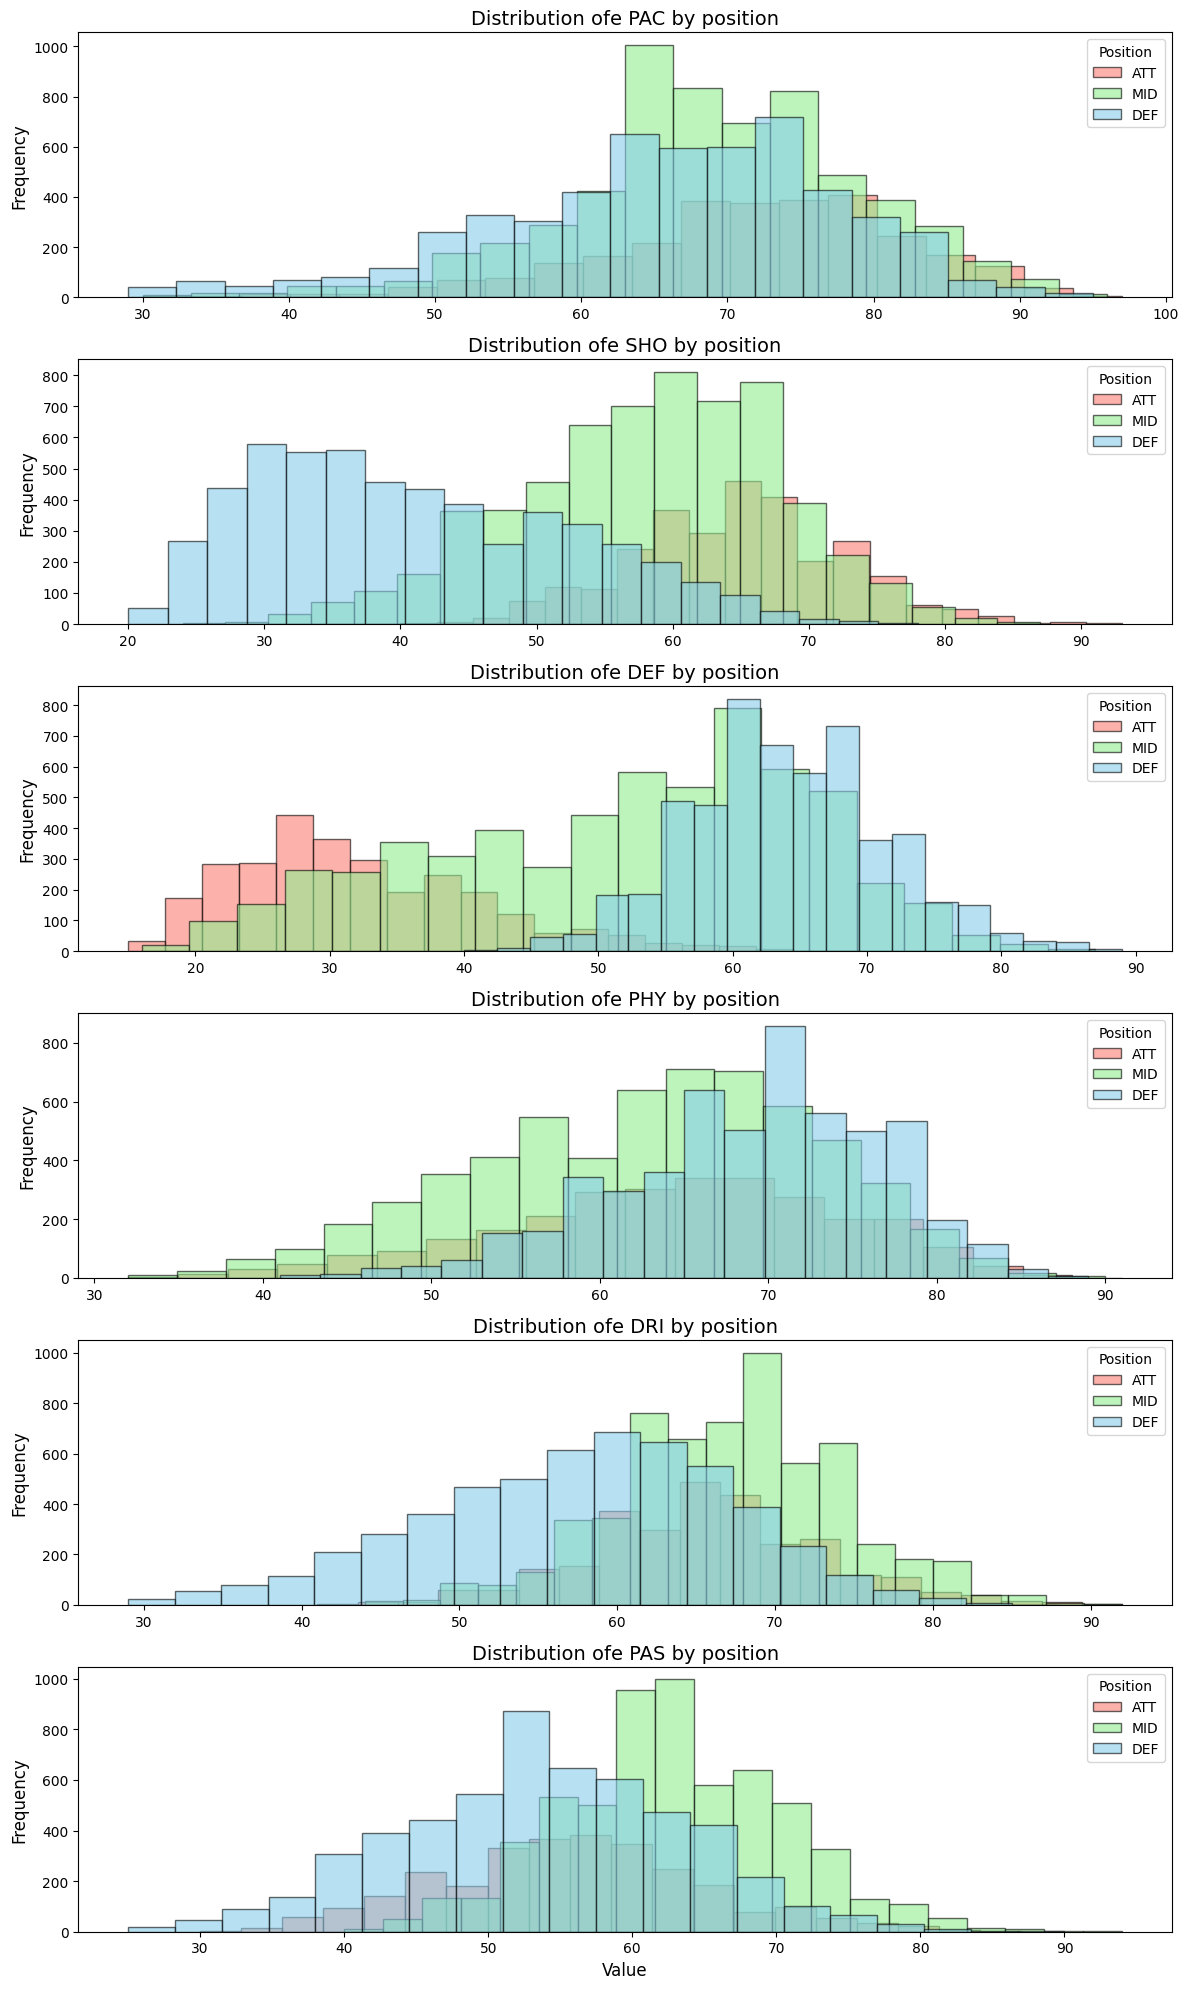

In [28]:
import matplotlib.pyplot as plt

features_to_analyze = ['PAC', 'SHO', 'DEF', 'PHY', 'DRI', 'PAS']
roles = ['ATT', 'MID', 'DEF']
colors = {'DEF': 'skyblue', 'MID': 'lightgreen', 'ATT': 'salmon'}
fig, axes = plt.subplots(len(features_to_analyze), 1, figsize=(12, 20), sharex=False)

for ax, feature in zip(axes, features_to_analyze):
    for role in roles:
        subset = data[data['Position'] == role]
        ax.hist(subset[feature], bins=20, alpha=0.6, label=f'{role}', color=colors[role], edgecolor='black')
    ax.set_title(f'Distribution of {feature} by position', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=12)
    ax.legend(title='Position')

plt.xlabel('Value', fontsize=12)
plt.tight_layout()
plt.show()

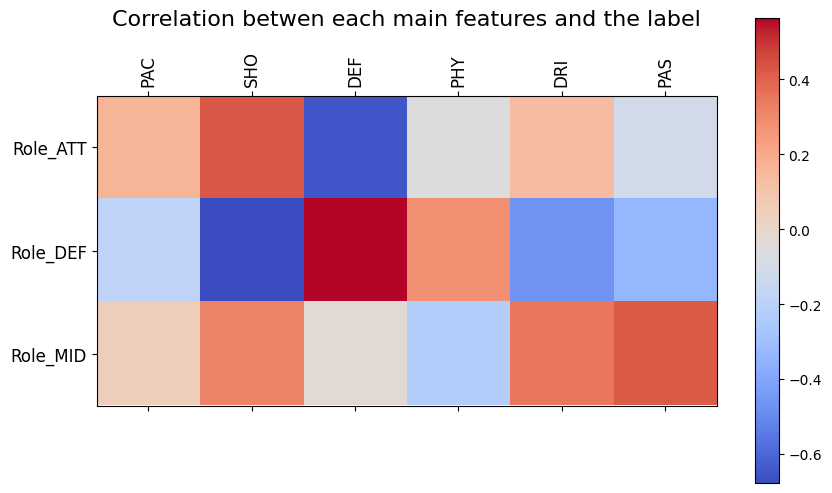

In [31]:
# Transformer les rôles en variables numériques via encodage one-hot
encoded_roles = pd.get_dummies(data['Position'], prefix='Role')

# Combiner les données encodées avec les attributs
correlation_data = pd.concat([encoded_roles, data[features_to_analyze]], axis=1)

# Calculer la matrice de corrélation
correlation_matrix = correlation_data.corr()

# Extraire les corrélations entre les rôles et les attributs
role_columns = [col for col in correlation_matrix.columns if 'Role_' in col]
attribute_columns = features_to_analyze

correlation_subset = correlation_matrix.loc[role_columns, attribute_columns]

# Visualiser la matrice de corrélation
plt.figure(figsize=(10, 6))
plt.matshow(correlation_subset, cmap='coolwarm', fignum=1)
plt.colorbar()
plt.title('Correlation betwen each main features and the label', y=1.2, fontsize=16)
plt.xticks(range(len(attribute_columns)), attribute_columns, rotation=90, fontsize=12)
plt.yticks(range(len(role_columns)), role_columns, fontsize=12)
plt.show()


As we can see from these graphs, some of these features are highly correlated with a label. This phenomenon encourages us to believe that there is indeed a link between features and labels, and that classification is therefore possible. The first stage of this analysis is now complete. 
Our dataset contains other features that would be interesting to analyse, but it could be that many of these additional features are very close or similar to our main data, so let's highlight this redundancy.


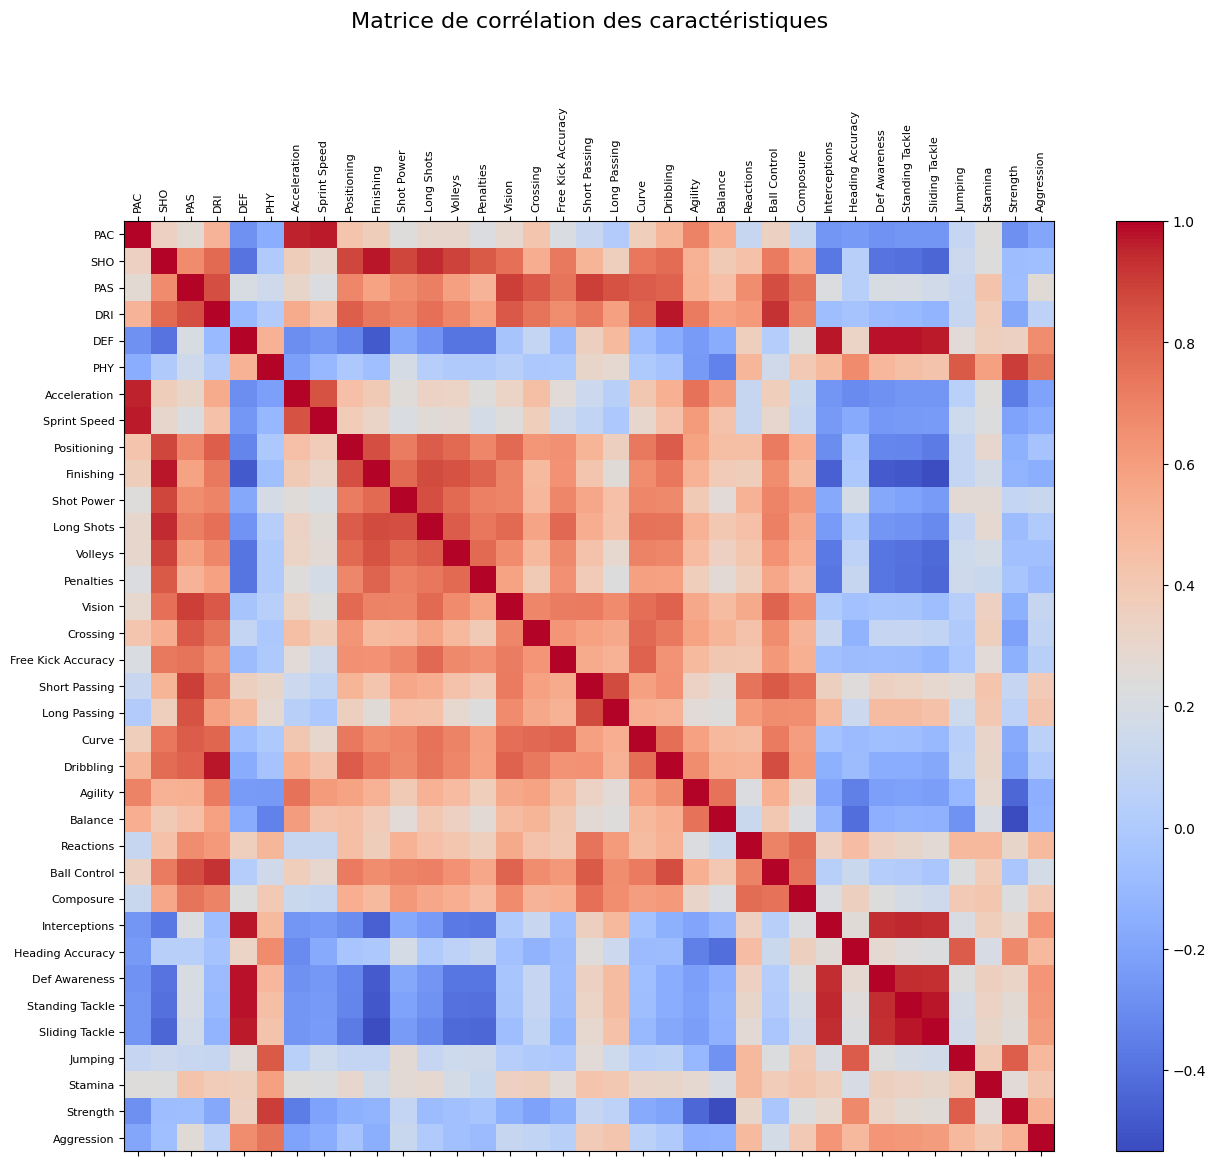

In [32]:
features_full = [
    'PAC', 'SHO', 'PAS', 'DRI', 'DEF', 'PHY', 'Acceleration', 'Sprint Speed',
    'Positioning', 'Finishing', 'Shot Power', 'Long Shots', 'Volleys', 'Penalties',
    'Vision', 'Crossing', 'Free Kick Accuracy', 'Short Passing', 'Long Passing',
    'Curve', 'Dribbling', 'Agility', 'Balance', 'Reactions', 'Ball Control',
    'Composure', 'Interceptions', 'Heading Accuracy', 'Def Awareness',
    'Standing Tackle', 'Sliding Tackle', 'Jumping', 'Stamina', 'Strength',
    'Aggression'
]

# Filtrer le dataframe pour les colonnes spécifiées
subset_data = data[features_full]

# Calculer la matrice de corrélation
correlation_matrix = subset_data.corr()

# Visualiser la matrice de corrélation
plt.figure(figsize=(16, 12))
plt.matshow(correlation_matrix, cmap='coolwarm', fignum=1)
plt.colorbar()
plt.title('Matrice de corrélation des caractéristiques', y=1.2, fontsize=16)
plt.xticks(range(len(features_full)), features_full, rotation=90, fontsize=8)
plt.yticks(range(len(features_full)), features_full, fontsize=8)
plt.show()

As we can see in this matrix, which shows the correlation between each feature, there are many features that are very closely correlated or even almost the same, the redundancy is very bad, so we are going to remove features that are too similar.
For example, variables that are highly correlated, such as maximum speed and sprint speed, could create redundancies. The team therefore selected key characteristics, such as PAC (speed), SHO (shooting) and DEF (defence), to reduce complexity while preserving data quality.

# Marque

In [ ]:
# Define features with more detailed stats than the base ones
features = [
    'PAC', 'SHO', 'PAS', 'DRI', 'DEF', 'PHY',              # Base stats on cards
    'Finishing', 'Heading Accuracy', 'Positioning',        # Attacking statistics 
    'Short Passing', 'Long Passing', 'Vision',             # Midfield statistics
    'Ball Control', 'Interceptions',                       # Defensive statistics
    'Agility', 'Balance', 'Stamina',             # Physical and agility stats 
]

# Drop rows with missing values for any of the selected features
data = data.dropna(subset=features)

# Define features and label
X = data[features] 
y = data['Position']

The characteristics selected are standardised so that their values are on a comparable scale. 

For example, a player's strength could be measured on a scale of 1 to 100, while his percentage of successful passes could be between 0 and 1. 

This step ensures that all characteristics contribute fairly to the model, without those with high values having a disproportionate influence.

In [ ]:
# Normalize the features 
scaler = StandardScaler()
X = scaler.fit_transform(X)

The data is divided into two sets: a training set <strong>(80% of the data)</strong> to train the model, and a test set <strong>(20% of the data)</strong> to evaluate its performance. This separation is important because it allows the model's effectiveness to be measured on data it has never seen before, simulating a real-life scenario.

In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Several machine learning models are used to predict player position, including KNN, Random Forest, SVM, and logistic regression (Softmax). Each model represents a different approach to supervised learning, and the performance of each will be compared to identify the one that best fits this problem.

In [ ]:
# Train multiple models and store them for future use
models = {
    'KNN': KNeighborsClassifier(n_neighbors=51),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM': SVC(kernel='linear', probability=True),
    'Logistic Regression (Softmax)': LogisticRegression(max_iter=200, multi_class='multinomial', solver='lbfgs')
}

Once the models have been trained, their performance is measured using metrics such as accuracy, classification ratios and confusion matrices. These tools enable us to understand the extent to which the model is capable of correctly predicting a player's position. 

For example, a confusion matrix shows the number of times an attacking player has been misclassified as a defender, which helps to identify specific weaknesses in the model.


In [ ]:
# Function to train and evaluate each model
def evaluate_models(models, X_train, X_test, y_train, y_test):
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"Accuracy of {model_name}: {accuracy * 100:.2f}%")
        print("Classification report:\n", classification_report(y_test, y_pred))
        print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
        print("\n" + "-"*50 + "\n")

For the KNN model, the choice of the number of neighbours <strong>K</strong> is crucial, as it directly influences the accuracy of predictions. A function is implemented to test different numbers of neighbours and visualise their impact on performance. This allows the optimal value of <strong>K</strong> to be chosen, ensuring that the KNN model performs at its best.


In [ ]:
# Function to determine the optimal K for KNN
def find_best_k(X_train, y_train, X_test, y_test):
    Ks = 100
    mean_acc = np.zeros((Ks-1))

    for n in range(1, Ks):
        neigh = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)
        yhat = neigh.predict(X_test)
        mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    # Plot accuracy vs K
    plt.plot(range(1, Ks), mean_acc, 'g')
    plt.ylabel('Accuracy')
    plt.xlabel('Number of Neighbors (K)')
    plt.title('Accuracy vs. Number of Neighbors (K)')
    plt.show()

    # Displays the best precision obtained and the corresponding k value.
    print("The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1)

A function has been developed to predict the position of a specific player based on his name. This feature illustrates how the model can be used in real-life situations. 

It looks up the player's statistics in the dataset, applies the same transformations as those used during training, and then uses the model to predict his position. This shows the practical and interactive aspect of the tool.

In [ ]:
# Function to predict player's position based on their name and chosen model
def predict_player_position(player_name, model, data, features, scaler):
    # Case-insensitive search for player's name
    player_data = data[data['Name'].str.contains(player_name, case=False, na=False)]
    
    if player_data.empty:
        print("Player not found!")
        return
    
    # Extract the player's features
    player_features = player_data[features].values
    
    # Normalize the player's features using the same scaler as the training data
    player_features_scaled = scaler.transform(player_features)
    
    # Predict the player's position using the selected model
    predicted_position = model.predict(player_features_scaled)
    
    # Extract first prediction if the result is an array
    predicted_position = predicted_position[0] if len(predicted_position) > 0 else predicted_position
    
    # Simplify predicted positions to broader categories
    if predicted_position in ["ST", "LW", "RW"]:
        predicted_position = "ATT"
    elif predicted_position in ["CM", "CDM", "CAM", "LM", "RM"]:
        predicted_position = "MID"
    elif predicted_position in ["LB", "RB", "CB"]:
        predicted_position = "DEF"

    print(f"The predicted position for {player_name} is: {predicted_position}")

# Conclusion

This project demonstrates how machine learning techniques can be applied to sports data to provide accurate and useful predictions. Through a methodical approach ranging from data preparation to model selection and evaluation, we have successfully exploited raw statistics to effectively rank football players according to their position on the pitch. This approach highlights the importance of data manipulation, the selection of relevant characteristics and the rigorous evaluation of models in order to obtain reliable and exploitable results.